# Knowledge Distillation



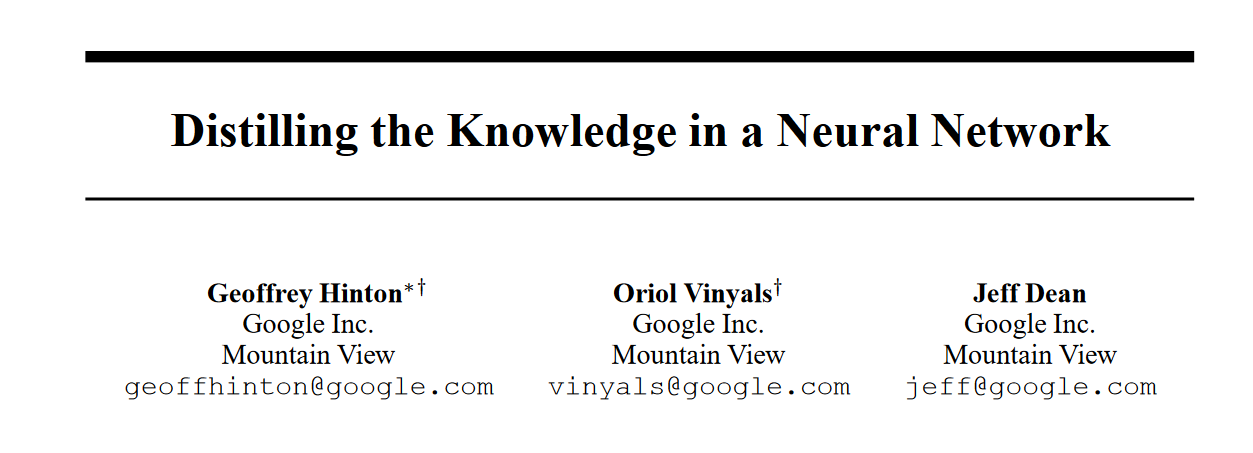

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Load in the dataset

In [2]:
transform_train = transforms.Compose([transforms.RandomCrop((28, 28), 2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))])
# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18245460.21it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 496169.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4555584.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4054166.58it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

cuda:0


(3, 242, 242)


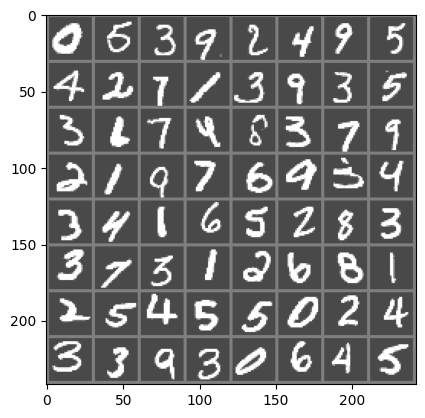

tensor([0, 5, 3, 9, 2, 4, 9, 5, 4, 2, 7, 1, 3, 9, 3, 5, 3, 6, 7, 4, 8, 3, 7, 9,
        2, 1, 9, 7, 6, 9, 3, 4, 3, 4, 1, 6, 5, 2, 8, 3, 3, 7, 3, 1, 2, 6, 8, 1,
        2, 5, 4, 5, 5, 0, 2, 4, 3, 3, 9, 3, 0, 6, 4, 5])


In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(labels)

## Create the Teacher Network Architechture

In [ ]:
class TeacherNetwork(nn.Module):
    def __init__(self):
        super(TeacherNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 10)
        self.dropout_input = 0.0
        self.dropout_hidden = 0.0
        self.is_training = True

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.dropout(x, p=self.dropout_input, training=self.is_training)
        x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_hidden, training=self.is_training)
        x = F.dropout(F.relu(self.fc2(x)), p=self.dropout_hidden, training=self.is_training)
        x = self.fc3(x)
        return x

teacher_network = TeacherNetwork()

summary(teacher_network, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1200]         942,000
            Linear-2                 [-1, 1200]       1,441,200
            Linear-3                   [-1, 10]          12,010
Total params: 2,395,210
Trainable params: 2,395,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 9.14
Estimated Total Size (MB): 9.16
----------------------------------------------------------------


In [8]:
import torch.nn as nn
import torch.nn.functional as F

#Create an over parameterized neural network, add dropout to prevent overfitting

class TeacherCNN(nn.Module):
    def __init__(self):
        super(TeacherCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

teacher_CNN = TeacherCNN().to(device)

summary(teacher_CNN, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
           Dropout-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 512]       4,719,104
           Dropout-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 4,743,050
Trainable params: 4,743,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 18.09
Estimated Total Size (MB): 18.62
----------------------------------------------------------------


In [9]:
def train(train_loader, model, epochs=10, max_iter=None):
    crossEL = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()

    for epoch in range(epochs):

        loss_total = 0
        num_iterations = 0

        data_iter = tqdm(train_loader, desc=f'Epoch {epoch+1}')

        for data in data_iter:
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = crossEL(outputs, labels)
            loss_total += loss.item()
            num_iterations += 1
            avg_loss = loss_total/num_iterations
            data_iter.set_postfix(loss=avg_loss)

            loss.backward()
            optimizer.step()

            if max_iter is not None and num_iterations >= max_iter:
                return

        print(f'Epoch {epoch+1}/{epochs} loss: {loss_total/num_iterations}')

train(train_loader, teacher_CNN, epochs=3)

Epoch 1: 100%|██████████| 938/938 [00:27<00:00, 33.83it/s, loss=1.61]


Epoch 1/3 loss: 1.6121209713695908


Epoch 2: 100%|██████████| 938/938 [00:27<00:00, 33.99it/s, loss=1.51]


Epoch 2/3 loss: 1.509908886733594


Epoch 3: 100%|██████████| 938/938 [00:27<00:00, 33.74it/s, loss=1.5]


Epoch 3/3 loss: 1.5025454929896764


In [10]:
def test(model):
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for digit {i} : {wrong_counts[i]}')

test(teacher_CNN)

Testing: 100%|██████████| 157/157 [00:02<00:00, 56.66it/s]

Accuracy: 0.969
wrong counts for digit 0 : 9
wrong counts for digit 1 : 10
wrong counts for digit 2 : 29
wrong counts for digit 3 : 11
wrong counts for digit 4 : 62
wrong counts for digit 5 : 24
wrong counts for digit 6 : 15
wrong counts for digit 7 : 96
wrong counts for digit 8 : 37
wrong counts for digit 9 : 22


## Once the cumbersome(teacher) model is trained we can distill its learned knowledge into a student model

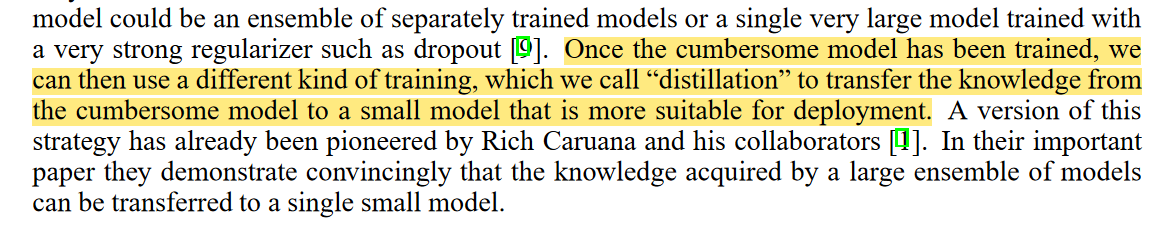

The trained teacher gets a 96.9 accuracy on the testset.

## Lets create a small student Neural Network

The small neural network is a simpler multi-layer perceptron, it is about ~400x smaller in parameter count comapared to the teacher.

In [11]:
class StudentNN(nn.Module):
    def __init__(self, hidden_layer_1=10, hidden_layer_2=200, hidden_layer_3=10):
        super(StudentNN, self).__init__()

        self.fc1 = nn.Linear(28*28, hidden_layer_1) # 784 x 10
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2) # 10 x 200
        self.fc3 = nn.Linear(hidden_layer_2, hidden_layer_3) # 200 x 10
        self.fc4 = nn.Linear(hidden_layer_3, 10) # 100 x 10 classes out
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28) #reshape and flatten the image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        output = F.softmax(x, dim=1)
        return output

student_mlp = StudentNN().to(device)

summary(student_mlp, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
              ReLU-2                   [-1, 10]               0
            Linear-3                  [-1, 200]           2,200
              ReLU-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
              ReLU-6                   [-1, 10]               0
            Linear-7                   [-1, 10]             110
Total params: 12,170
Trainable params: 12,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


## Let's get a baseline for the students performance without distilling the teacher knowledge into it

In [12]:
#Baseline Student performance
train(train_loader, student_mlp, epochs=3)
test(student_mlp)

Epoch 1: 100%|██████████| 938/938 [00:24<00:00, 38.07it/s, loss=1.89]


Epoch 1/3 loss: 1.8945043956292973


Epoch 2: 100%|██████████| 938/938 [00:26<00:00, 35.81it/s, loss=1.73]


Epoch 2/3 loss: 1.7255683870457892


Epoch 3: 100%|██████████| 938/938 [00:29<00:00, 31.85it/s, loss=1.7]


Epoch 3/3 loss: 1.696153700987159


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.21it/s]

Accuracy: 0.825
wrong counts for digit 0 : 17
wrong counts for digit 1 : 14
wrong counts for digit 2 : 129
wrong counts for digit 3 : 151
wrong counts for digit 4 : 89
wrong counts for digit 5 : 88
wrong counts for digit 6 : 50
wrong counts for digit 7 : 1028
wrong counts for digit 8 : 120
wrong counts for digit 9 : 69


## The student model gets an 82.5% accuracy. Lets retrain the student model using the teacher model this time.

## The goal is to use the probability distribution of the teacher model as a guide for the student. When the student starts to mimic the output distribution of the teacher over digit classes we can say that is learning from the teacher.

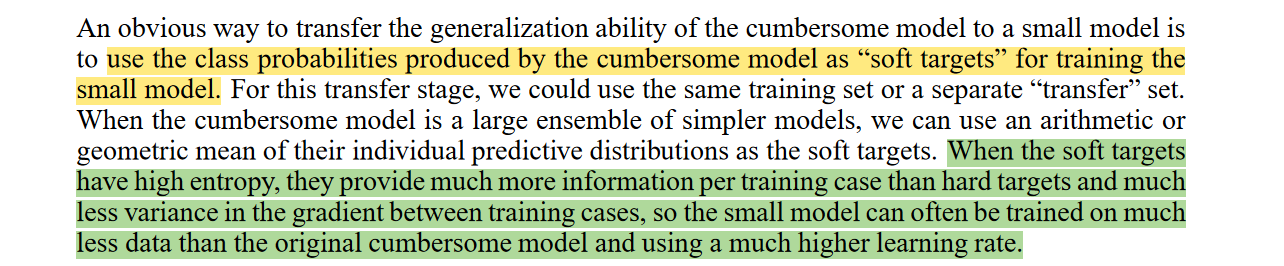

## In extracting the knowledge from the teacher model we want to increase the temperature so that it doesn't just give near zero probabilities to the incorrecty answers, we want signal as to what the 2nd, 3rd etc choices might have been for the model if it were given a top k chances to get the answer correct. This is valuable information that the student model can learn to mimic and understand the problem better.
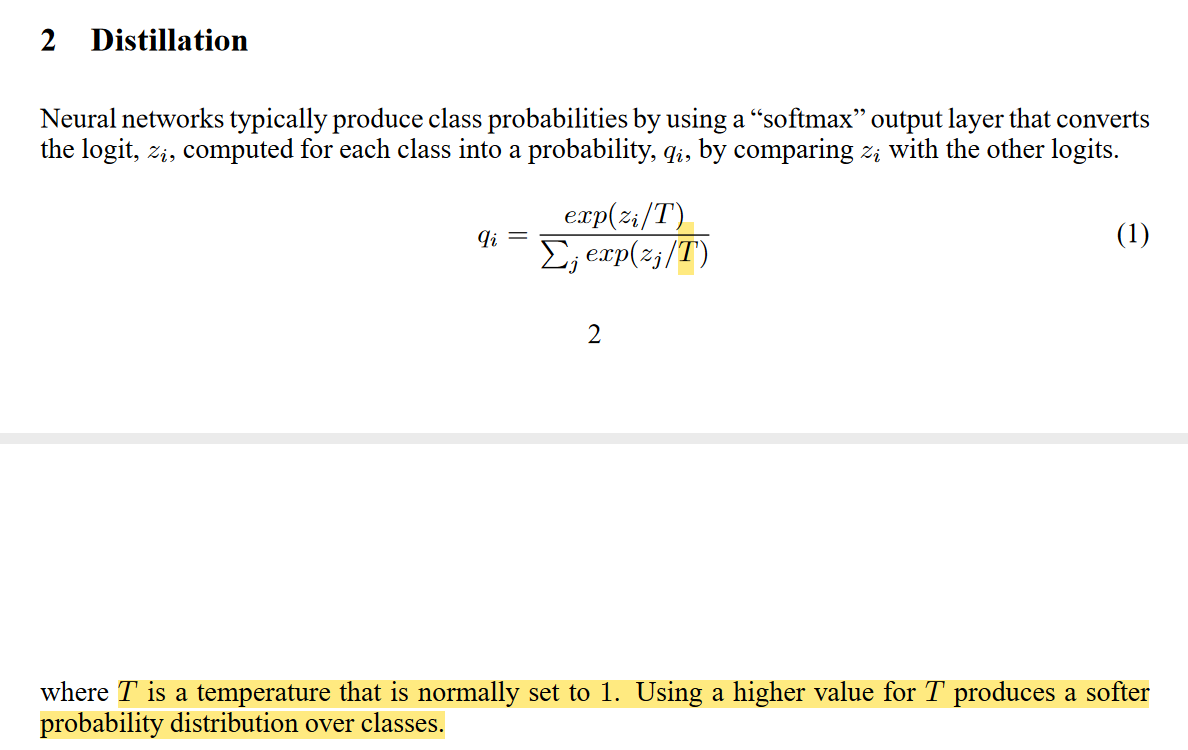

## Distilled information from the teacher model is not enough to guide the student network so to make it err on the correct side we create a combined loss function which takes into account how far the students answers are from the teachers and ALSO how far they are from the correct answer-> Total_loss = distilled_loss + original_loss

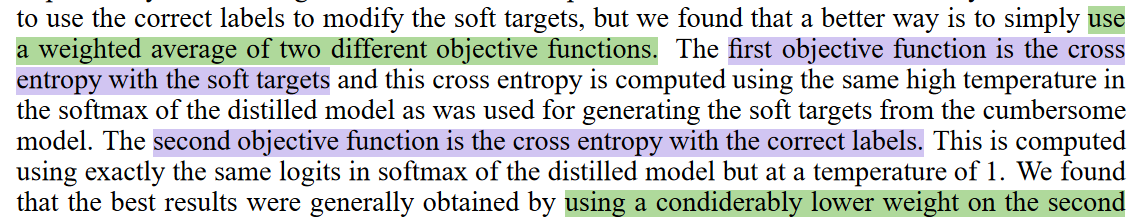

In [13]:
def distill_train(train_loader, student_model, teacher_model, T, learning_rate,
                  soft_target_loss_weight, ce_loss_weight, epochs=10, max_iter=None):

    ce_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)

    teacher_model.eval()
    student_model.train()

    for epoch in range(epochs):

        loss_total = 0
        num_iterations = 0

        data_iter = tqdm(train_loader, desc=f'Epoch {epoch+1}')

        for data in data_iter:
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                soft_probs = teacher_model(inputs)

            student_probs = student_model(inputs)

            soft_target_loss = ce_loss(student_probs/T, soft_probs/T)

            label_loss = ce_loss(student_probs, labels)

            loss = (T**2) * (soft_target_loss_weight * soft_target_loss) + (ce_loss_weight * label_loss)

            loss.backward()
            optimizer.step()

            loss_total += loss.item()
            num_iterations += 1
            avg_loss = loss_total/num_iterations

            data_iter.set_postfix(loss=avg_loss)

            if max_iter is not None and num_iterations >= max_iter:
                return

        print(f'Epoch {epoch+1}/{epochs} loss: {loss_total/num_iterations}')


## We add a T^2 term because the gradients produced by the distilled loss scale as 1/T^2 so we scale them back up

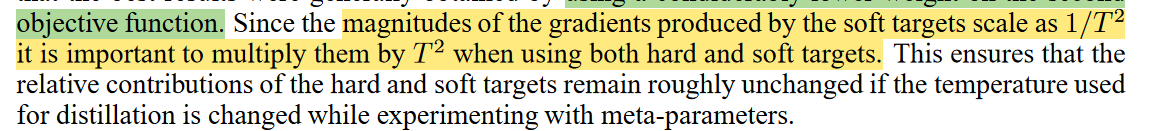

## Below we distill the teacher network into the student network

In [19]:
student_mlp_to_distill = StudentNN().to(device)

distill_train(train_loader, student_model=student_mlp_to_distill, teacher_model=teacher_CNN,
              T=1, learning_rate=0.001, soft_target_loss_weight=0.65,
              ce_loss_weight=0.35, epochs=3)

test(student_mlp_to_distill)

Epoch 1: 100%|██████████| 938/938 [00:26<00:00, 36.03it/s, loss=1.86]


Epoch 1/3 loss: 1.860460130517671


Epoch 2: 100%|██████████| 938/938 [00:25<00:00, 36.15it/s, loss=1.72]


Epoch 2/3 loss: 1.7234868123841438


Epoch 3: 100%|██████████| 938/938 [00:25<00:00, 36.39it/s, loss=1.69]


Epoch 3/3 loss: 1.6939305694881024


Testing: 100%|██████████| 157/157 [00:02<00:00, 52.51it/s]

Accuracy: 0.82
wrong counts for digit 0 : 51
wrong counts for digit 1 : 38
wrong counts for digit 2 : 85
wrong counts for digit 3 : 114
wrong counts for digit 4 : 982
wrong counts for digit 5 : 235
wrong counts for digit 6 : 35
wrong counts for digit 7 : 116
wrong counts for digit 8 : 65
wrong counts for digit 9 : 78


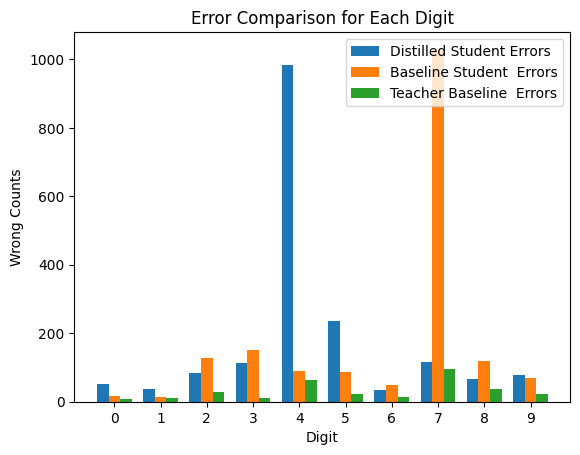

In [24]:
import matplotlib.pyplot as plt
import numpy as np

digits = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
wrong_counts_model = np.array([51, 38, 85, 114, 982, 235, 35, 116, 65, 78])
wrong_counts_baseline = np.array([17, 14, 129, 151, 89, 88, 50, 1028, 120, 69])
wrong_counts_teacher = np.array([9, 10, 29, 11, 62, 24, 15, 96, 37, 22])

bar_width = 0.25
index = np.arange(len(digits))

plt.bar(index, wrong_counts_model, bar_width, label='Distilled Student Errors')
plt.bar(index + bar_width, wrong_counts_baseline, bar_width, label='Baseline Student  Errors')
plt.bar(index + 2 * bar_width, wrong_counts_teacher, bar_width, label='Teacher Baseline  Errors')

plt.xlabel('Digit')
plt.ylabel('Wrong Counts')
plt.title('Error Comparison for Each Digit')
plt.xticks(index + bar_width, digits)
plt.legend()

plt.show()


## Interesting Observations:
-  Don't know what happened to distilled student for `4`
-  `7` was significantly improved using the distilled knowledge
-  `2`, `3`, `6`, `8` performance improves compared to baseline
- `0`, `1`, `5`, `9` performance gets worse